<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/01.webp?timestamp=1" width="800px">

# Stage 1 - Building an LLM
## 1. Data preparation & sampling

In [131]:
from importlib.metadata import version
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.4.1
tiktoken version: 0.7.0


### 1.1 Understanding word embeddings
- There are many forms of embeddings; we focus on text embeddings

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/02.webp" width="600px">


- LLMs work with embeddings in high-dimensional spaces (i.e., thousands of dimensions)
- Since we can't visualize such high-dimensional spaces (we humans think in 1, 2, or 3 dimensions), the figure below illustrates a 2-dimensional embedding space

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/03.webp" width="400px">


### 1.2 Tokenizing Text

- In this section, we tokenize text, which means breaking text into smaller units, such as individual words and punctuation characters
- Following this, these tokens will be transformed into token IDs based on a predefined vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/19.webp" width="400px">


- Load raw text we want to work with
- [The Verdict by Edith Wharton](https://en.wikisource.org/wiki/The_Verdict) is a public domain short story

In [132]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [133]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character(s):", len(raw_text))
print(raw_text[:5])
print(raw_text[:40])

Total number of character(s): 20479
I HAD
I HAD always thought Jack Gisburn rather


- Let's develop a simple tokenizer based on some simple sample text that we can then later apply to the text above
- The following regular expression will split on whitespace

In [134]:
import re

text = "Hello, world. This, is a test."
result = re.split(r"(\s)", text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


- We need to split on whitespace as well as also commas and periods

In [135]:
result = re.split(r"([,.]|\s)", text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


- This creates empty strings, let's remove them

In [136]:
# Strip whitespace from each item and then filter out any empty strings and whitespaces.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


- Let's **handle** punctuation, such as periods, question marks, and so on

In [137]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


- Now ready to apply this tokenization to the raw text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/05.webp" width="400px">

In [138]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


- Let's calculate the total number of tokens

In [139]:
print(len(preprocessed))

4690


### 1.3 Converting tokens into token IDs

- Convert the text tokens into token IDs that will be process via embedding layers later

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/06.webp" width="600px">

- From these tokens, we can now build a vocabulary that consists of all the unique tokens

In [140]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)
print(type(all_words))

1130
<class 'list'>


In [141]:
vocab = {token:integer for integer, token in enumerate(all_words)}

- Below are the first 50 entries in this vocabulary:

In [142]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


- Below, we illustrate the tokenization of a short sample text using a small vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/07.webp?123" width="500px">

- Putting it now all together into a tokenizer class

In [143]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {id:token for token,id in vocab.items()} 

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[token] for token in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[id] for id in ids])
         # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

- The `encode` function turns text into token IDs
- The `decode` function turns token IDs back into text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/08.webp?123" width="600px">

In [144]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


- We can decode the integers back into text

In [145]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

### 1.4 Adding special context tokens

- It's useful to add some "special" tokens for unknown words and to denote the end of a text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/09.webp?123" width="600px">

- Some tokenizers use special tokens to help the LLM with additional context
- Some of these special tokens are
  - `[BOS]` (beginning of sequence) marks the beginning of text
  - `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
  - `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- `[UNK]` to represent words that are not included in the vocabulary

- Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity
- The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above
- GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)
- GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section

- We use the `<|endoftext|>` tokens between two independent sources of text:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/10.webp" width="600px">

In [146]:
# tokenizer = SimpleTokenizerV1(vocab)

# text = "Hello, do you like tea. Is this-- a test?"

# tokenizer.encode(text)

- The above produces an error because the word "Hello" is not contained in the vocabulary
- To deal with such cases, we can add special tokens like `"<|unk|>"` to the vocabulary to represent unknown words
- Since we are already extending the vocabulary, let's add another token called `"<|endoftext|>"` which is used in GPT-2 training to denote the end of a text (and it's also used between concatenated text, like if our training datasets consists of multiple articles, books, etc.)

In [147]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer, token in enumerate(all_tokens)}

In [148]:
len(vocab.items())

1132

In [149]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


- We also need to adjust the tokenizer accordingly so that it knows when and how to use the new `<unk>` token

In [150]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {id:token for token,id in vocab.items()} 

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>"  for item in preprocessed]
        ids = [self.str_to_int[token] for token in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[id] for id in ids])
         # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

- Let's try to tokenize text with the modified tokenizer:

In [151]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [152]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [153]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

## 2.5 BytePair encoding

- GPT-2 used BytePair encoding (BPE) as its tokenizer
- It allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
- In this chapter, we are using the BPE tokenizer from OpenAI's open-source [tiktoken](https://github.com/openai/tiktoken) library, which implements its core algorithms in Rust to improve computational performance
- I created a notebook in the [./bytepair_encoder](../02_bonus_bytepair-encoder) that compares these two implementations side-by-side (tiktoken was about 5x faster on the sample text)

In [154]:
import importlib
import importlib.metadata
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.7.0


In [155]:
tokenizer = tiktoken.get_encoding("gpt2")

In [156]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [157]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


- BPE tokenizers break down unknown words into subwords and individual characters:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/11.webp" width="500px">

### 1.6 Data sampling with a sliding window

- We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/12.webp" width="600px">

In [158]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


- For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

In [159]:
enc_sample = enc_text[50:]
print(enc_sample)

[290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536, 5469, 438, 14363, 938, 4842, 1650, 353, 438, 2934, 489, 3255, 465, 48422, 540, 450, 67, 3299, 13, 366, 5189, 1781, 340, 338, 1016, 284, 3758, 262, 1988, 286, 616, 4286, 705, 1014, 510, 26, 475, 314, 836, 470, 892, 286, 326, 11, 1770, 13, 8759, 2763, 438, 1169, 2994, 284, 943, 17034, 318, 477, 314, 892, 286, 526, 383, 1573, 11, 319, 9074, 13, 536, 5469, 338, 11914, 11, 33096, 663, 4808, 3808, 62, 355, 996, 484, 547, 12548, 287, 281, 13079, 410, 12523, 286, 22353, 13, 843, 340, 373, 407, 691, 262, 9074, 13, 536, 48819, 508, 25722, 276, 13, 11161, 407, 262, 40123, 18113, 544, 9325, 701, 11, 379, 262, 938, 402, 1617, 261, 12917, 905, 11, 5025, 502, 878, 402, 271, 10899, 338, 366, 31640, 12, 67, 20811, 1, 284, 910, 11, 351, 10

In [160]:
context_size = 4

x = enc_sample[:4]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:       {y}")

x: [290, 4920, 2241, 287]
y:       [4920, 2241, 287, 257]


- One by one, the prediction would look like as follows:

In [161]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [162]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


- For now, we implement a simple data loader that iterates over the input dataset and returns the inputs and targets shifted by one

In [163]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1+cpu


- We use a sliding window approach, changing the position by +1:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/13.webp?123" width="600px">

- Create dataset and dataloader that extract chunks from the input text dataset
- `max_length`: The maximum number of tokens that the model can handle in one pass. You want to split or chunk your input token_ids into sections, each of length `max_length`, to avoid exceeding the model's limit.
- If `max_length` = 512 and `stride` = 128, you will process overlapping chunks of size 512, but each new chunk will start 128 tokens after the previous one.

In [164]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i+max_length]
            target_chunk = token_ids[i+1 : i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [165]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

- Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4

In [166]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [167]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=2, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
print(data_iter)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 1807]]), tensor([[ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619]])]


In [168]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[2885, 1464, 1807, 3619],
        [1464, 1807, 3619,  402]]), tensor([[1464, 1807, 3619,  402],
        [1807, 3619,  402,  271]])]


- An example using stride equal to the context length (here: 4) as shown below:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/14.webp" width="600px">


- We can also create batched outputs
- Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting

In [169]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


### 1.7 Creating token embeddings

- The data is already almost ready for an LLM
- But lastly let us embed the tokens in a continuous vector representation using an embedding layer
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/15.webp" width="500px">



- Suppose we have the following four input examples with input ids 5, 1, 3, and 2 (after tokenization):

In [170]:
input_ids = torch.tensor([5, 1, 3, 2])

- For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [171]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- This would result in a 6x3 weight matrix:

In [172]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


- For those who are familiar with one-hot encoding, the embedding layer approach above is essentially just a more efficient way of implementing one-hot encoding followed by matrix multiplication in a fully-connected layer, which is described in the supplementary code in [./embedding_vs_matmul](../03_bonus_embedding-vs-matmul)
- Because the embedding layer is just a more efficient implementation that is equivalent to the one-hot encoding and matrix-multiplication approach it can be seen as a neural network layer that can be optimized via backpropagation

- To convert a token with id 2 into a 3-dimensional vector, we do the following:

In [173]:
print(embedding_layer(torch.tensor([2])))

tensor([[ 1.2753, -0.2010, -0.1606]], grad_fn=<EmbeddingBackward0>)


- Note that the above is the 3rd row in the `embedding_layer` weight matrix
- To embed all four `input_ids` values above, we do

In [174]:
print(embedding_layer(input_ids))

tensor([[-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010],
        [-0.4015,  0.9666, -1.1481],
        [ 1.2753, -0.2010, -0.1606]], grad_fn=<EmbeddingBackward0>)


- An embedding layer is essentially a look-up operation:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/16.webp?123" width="600px">

### 1.8 Encoding word positions

- Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/17.webp" width="600px">


- Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/18.webp" width="600px">


- The BytePair encoder has a vocabulary size of 50,257:
- Suppose we want to encode the input tokens into a 256-dimensional vector representation:

In [175]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector
- If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:

In [176]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [177]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


- GPT-2 uses absolute position embeddings, so we just create another embedding layer:

In [178]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim) 

In [179]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


- To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [180]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


- In the initial phase of the input processing workflow, the input text is segmented into separate tokens
- Following this segmentation, these tokens are transformed into token IDs based on a predefined vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/19.webp" width="500px">

### 1.9 Data Loading Pipeline Summarized

In [181]:
# NBVAL_SKIP
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.4.1
tiktoken version: 0.7.0


In [182]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

tokenizer = tiktoken.get_encoding("gpt2")
encoded_text = tokenizer.encode(raw_text)

vocab_size = 50257
output_dim = 256
context_length = 1024


token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length)

In [183]:
for batch in dataloader:
    x, y = batch

    token_embeddings = token_embedding_layer(x)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))

    input_embeddings = token_embeddings + pos_embeddings

    break

In [184]:
print(input_embeddings.shape)

torch.Size([8, 4, 256])


# 2. Attention Mechanisms

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/01.webp?123" width="600px">


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/02.webp" width="600px">

### 2.1 The problem with modeling long sequences

- Translating a text, word by word isn't feasible due to the differences in grammatical structures between the source and target languages:


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/03.webp" width="600px">


- Prior to the introduction of transformer models, encoder-decoder RNNs were commonly used for machine translation tasks
- In this setup, the encoder processes a sequence of tokens from the source language, using a hidden state—a kind of intermediate layer within the neural network—to generate a condensed representation of the entire input sequence:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/04.webp" width="600px">

### 2.2 Capturing data dependencies with attention mechanisms

- Through an attention mechanism, the text-generating decoder segment of the network is capable of selectively accessing all input tokens, implying that certain input tokens hold more significance than others in the generation of a specific output token


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/05.webp" width="600px">


- Self-attention in transformers is a technique designed to enhance input representations by enabling each position in a sequence to engage with and determine the relevance of every other position within the same sequence

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/06.webp" width="400px">


### 2.3 Attending to different parts of the input with self-attention

#### 2.3.1 A simple self-attention mechanism without trainable weights


- This section explains a very simplified variant of self-attention, which does not contain any trainable weights
- This is purely for illustration purposes and NOT the attention mechanism that is used in transformers
- The next section, section 3.3.2, will extend this simple attention mechanism to implement the real self-attention mechanism
- Suppose we are given an input sequence $x^{(1)}$ to $x^{(T)}$
  - The input is a text (for example, a sentence like "Your journey starts with one step") that has already been converted into token embeddings as described in chapter 2
  - For instance, $x^{(1)}$ is a d-dimensional vector representing the word "Your", and so forth
- **Goal:** compute context vectors $z^{(i)}$ for each input sequence element $x^{(i)}$ in $x^{(1)}$ to $x^{(T)}$ (where $z$ and $x$ have the same dimension)
    - A context vector $z^{(i)}$ is a weighted sum over the inputs $x^{(1)}$ to $x^{(T)}$
    - The context vector is "context"-specific to a certain input
      - Instead of $x^{(i)}$ as a placeholder for an arbitrary input token, let's consider the second input, $x^{(2)}$
      - And to continue with a concrete example, instead of the placeholder $z^{(i)}$, we consider the second output context vector, $z^{(2)}$
      - The second context vector, $z^{(2)}$, is a weighted sum over all inputs $x^{(1)}$ to $x^{(T)}$ weighted with respect to the second input element, $x^{(2)}$
      - The attention weights are the weights that determine how much each of the input elements contributes to the weighted sum when computing $z^{(2)}$
      - In short, think of $z^{(2)}$ as a modified version of $x^{(2)}$ that also incorporates information about all other input elements that are relevant to a given task at hand

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/07.webp" width="600px">

- (Please note that the numbers in this figure are truncated to one
digit after the decimal point to reduce visual clutter; similarly, other figures may also contain truncated values)

- By convention, the unnormalized attention weights are referred to as **"attention scores"** whereas the normalized attention scores, which sum to 1, are referred to as **"attention weights"**


- The code below walks through the figure above step by step

<br>

- **Step 1:** compute unnormalized attention scores $\omega$
- Suppose we use the second input token as the query, that is, $q^{(2)} = x^{(2)}$, we compute the unnormalized attention scores via dot products:
    - $\omega_{21} = x^{(1)} q^{(2)\top}$
    - $\omega_{22} = x^{(2)} q^{(2)\top}$
    - $\omega_{23} = x^{(3)} q^{(2)\top}$
    - ...
    - $\omega_{2T} = x^{(T)} q^{(2)\top}$
- Above, $\omega$ is the Greek letter "omega" used to symbolize the unnormalized attention scores
    - The subscript "21" in $\omega_{21}$ means that input sequence element 2 was used as a query against input sequence element 1






- Suppose we have the following input sentence that is already embedded in 3-dimensional vectors as described in chapter 3 (we use a very small embedding dimension here for illustration purposes, so that it fits onto the page without line breaks):

In [185]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)


- (In this book, we follow the common machine learning and deep learning convention where training examples are represented as rows and feature values as columns; in the case of the tensor shown above, each row represents a word, and each column represents an embedding dimension)

- The primary objective of this section is to demonstrate how the context vector $z^{(2)}$
  is calculated using the second input sequence, $x^{(2)}$, as a query

- The figure depicts the initial step in this process, which involves calculating the attention scores ω between $x^{(2)}$
  and all other input elements through a dot product operation


  <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/08.webp" width="600px">


- We use input sequence element 2, $x^{(2)}$, as an example to compute context vector $z^{(2)}$; later in this section, we will generalize this to compute all context vectors.
- The first step is to compute the unnormalized attention scores by computing the dot product between the query $x^{(2)}$ and all other input tokens:


In [186]:
query = inputs[2] # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
print(attn_scores_2)
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) #  # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([    -0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000])
tensor([0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605])


- Side note: a dot product is essentially a shorthand for multiplying two vectors elements-wise and summing the resulting products:

In [187]:
res = 0

for idx, elements in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]

print(res)
print(torch.dot(inputs[0], query))

tensor(0.9422)
tensor(0.9422)


- **Step 2:** normalize the unnormalized attention scores ("omegas", $\omega$) so that they sum up to 1
- Here is a simple way to normalize the unnormalized attention scores to sum up to 1 (a convention, useful for interpretation, and important for training stability):


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/09.webp" width="600px">

In [188]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1454, 0.2277, 0.2248, 0.1280, 0.1104, 0.1637])
Sum: tensor(1.)


- However, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.
- Here's a naive implementation of a softmax function for scaling, which also normalizes the vector elements such that they sum up to 1:

In [189]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565])
Sum: tensor(1.)


- The naive implementation above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues
- Hence, in practice, it's recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [190]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565])
Sum: tensor(1.0000)


- **Step 3**: compute the context vector $z^{(2)}$ by multiplying the embedded input tokens, $x^{(i)}$ with the attention weights and sum the resulting vectors:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/10.webp" width="600px">

In [191]:
query = inputs[1] # 2nd input tokens is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i

print(context_vec_2)

tensor([0.4431, 0.6496, 0.5671])


#### 2.3.2 Computing attention weights for all input tokens

##### Generalize to all input sequence tokens:

- Above, we computed the attention weights and context vector for input 2 (as illustrated in the highlighted row in the figure below)
- Next, we are generalizing this computation to compute all attention weights and context vectors


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/11.webp" width="600px">

- (Please note that the numbers in this figure are truncated to two
digits after the decimal point to reduce visual clutter; the values in each row should add up to 1.0 or 100%; similarly, digits in other figures are truncated)




- In self-attention, the process starts with the calculation of attention scores, which are subsequently normalized to derive attention weights that total 1
- These attention weights are then utilized to generate the context vectors through a weighted summation of the inputs


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/12.webp" width="600px">

- Apply previous **step 1** to all pairwise elements to compute the unnormalized attention score matrix:

In [192]:
attn_scores = torch.empty(6,6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


- We can achieve the same as above more efficiently via matrix multiplication:

In [193]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


- Similar to **step 2** previously, we normalize each row so that the values in each row sum to 1:

In [194]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


- Quick verification that the values in each row indeed sum to 1:

In [195]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


- Apply previous **step 3** to compute all context vectors:

In [196]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


-  As a sanity check, the previously computed context vector $z^{(2)} = [0.4419, 0.6515, 0.5683]$ can be found in the 2nd row in above: 

In [197]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4431, 0.6496, 0.5671])


### 2.4 Implementing self-attention with trainable weights

- A conceptual framework illustrating how the self-attention mechanism developed in this section integrates into the overall narrative and structure of this book and chapter

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/13.webp" width="600px">

#### 2.4.1 Computing the attention weights step by step


- In this section, we are implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other popular LLMs
- This self-attention mechanism is also called "scaled dot-product attention"
- The overall idea is similar to before:
  - We want to compute context vectors as weighted sums over the input vectors specific to a certain input element
  - For the above, we need attention weights
- As you will see, there are only slight differences compared to the basic attention mechanism introduced earlier:
  - The most notable difference is the introduction of weight matrices that are updated during model training
  - These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce "good" context vectors


  <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/14.webp" width="600px">


- Implementing the self-attention mechanism step by step, we will start by introducing the three training weight matrices $W_q$, $W_k$, and $W_v$
- These three matrices are used to project the embedded input tokens, $x^{(i)}$, into query, key, and value vectors via matrix multiplication:

  - Query vector: $q^{(i)} = W_q \,x^{(i)}$
  - Key vector: $k^{(i)} = W_k \,x^{(i)}$
  - Value vector: $v^{(i)} = W_v \,x^{(i)}$



- The embedding dimensions of the input $x$ and the query vector $q$ can be the same or different, depending on the model's design and specific implementation
- In GPT models, the input and output dimensions are usually the same, but for illustration purposes, to better follow the computation, we choose different input and output dimensions here:

In [198]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

- Below, we initialize the three weight matrices; note that we are setting `requires_grad=False` to reduce clutter in the outputs for illustration purposes, but if we were to use the weight matrices for model training, we would set `requires_grad=True` to update these matrices during model training

In [199]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

- Next we compute the query, key, and value vectors:

In [200]:
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


- As we can see below, we successfully projected the 6 input tokens from a 3D onto a 2D embedding space:

In [201]:
keys = inputs @ W_key 
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


- In the next step, **step 2**, we compute the unnormalized attention scores by computing the dot product between the query and each key vector:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/15.webp" width="600px">

In [202]:
keys_2 = keys[1] # Python starts index at 0
attn_scores_22 = query_2.dot(keys_2)
print(attn_scores_22)

tensor(1.8524)


- Since we have 6 inputs, we have 6 attention scores for the given query vector:

In [203]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/16.webp" width="600px">

- Next, in **step 3**, we compute the attention weights (normalized attention scores that sum up to 1) using the softmax function we used earlier
- The difference to earlier is that we now scale the attention scores by dividing them by the square root of the embedding dimension, $\sqrt{d_k}$ (i.e., `d_k**0.5`):

In [204]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/17.webp" width="600px">

- In **step 4**, we now compute the context vector for input query vector 2:

In [205]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


#### 2.4.2 Implementing a compact SelfAttention class

- Putting it all together, we can implement the self-attention mechanism as follows:

In [206]:
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/18.webp" width="600px">

- We can streamline the implementation above using PyTorch's Linear layers, which are equivalent to a matrix multiplication if we disable the bias units
- Another big advantage of using `nn.Linear` over our manual `nn.Parameter(torch.rand(...)` approach is that `nn.Linear` has a preferred weight initialization scheme, which leads to more stable model training

In [207]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


- Note that `SelfAttention_v1` and `SelfAttention_v2` give different outputs because they use different initial weights for the weight matrices

### 2.5 Hiding future words with causal attention

- In causal attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/19.webp" width="600px">

#### 2.5.1 Applying a causal attention mask

- In this section, we are converting the previous self-attention mechanism into a causal self-attention mechanism
- Causal self-attention ensures that the model's prediction for a certain position in a sequence is only dependent on the known outputs at previous positions, not on future positions
- In simpler words, this ensures that each next word prediction should only depend on the preceding words
- To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text):


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/20.webp" width="600px">


- To illustrate and implement causal self-attention, let's work with the attention scores and weights from the previous section: 

In [208]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


- The simplest way to mask out future attention weights is by creating a mask via PyTorch's tril function with elements below the main diagonal (including the diagonal itself) set to 1 and above the main diagonal set to 0:

In [209]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


- Then, we can multiply the attention weights with this mask to zero out the attention scores above the diagonal:

In [210]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


- However, if the mask were applied after softmax, like above, it would disrupt the probability distribution created by softmax
- Softmax ensures that all output values sum to 1
- Masking after softmax would require re-normalizing the outputs to sum to 1 again, which complicates the process and might lead to unintended effects


- To make sure that the rows sum to 1, we can normalize the attention weights as follows:

In [211]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


- While we are technically done with coding the causal attention mechanism now, let's briefly look at a more efficient approach to achieve the same as above
- So, instead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/21.webp" width="500px">

In [212]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


- As we can see below, now the attention weights in each row correctly sum to 1 again:

In [213]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


#### 2.5.2 Masking additional attention weights with dropout

- In addition, we also apply dropout to reduce overfitting during training
- Dropout can be applied in several places:
  - for example, after computing the attention weights;
  - or after multiplying the attention weights with the value vectors
- Here, we will apply the dropout mask after computing the attention weights because it's more common

- Furthermore, in this specific example, we use a dropout rate of 50%, which means randomly masking out half of the attention weights. (When we train the GPT model later, we will use a lower dropout rate, such as 0.1 or 0.2


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/22.webp" width="600px">


- If we apply a dropout rate of 0.5 (50%), the non-dropped values will be scaled accordingly by a factor of 1/0.5 = 2.

In [214]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [215]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


#### 2.5.3 Implementing a compact causal self-attention class
- Now, we are ready to implement a working implementation of self-attention, including the causal and dropout masks
- One more thing is to implement the code to handle batches consisting of more than one input so that our `CausalAttention` class supports the batch outputs produced by the data loader we implemented in chapter 2
- For simplicity, to simulate such batch input, we duplicate the input text example:

In [216]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


In [217]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- Note that dropout is only applied during training, not during inference

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/23.webp" width="600px">

### 2.6 Extending single-head attention to multi-head attention

### 2.6.1 Stacking multiple single-head attention layers

- Below is a summary of the self-attention implemented previously (causal and dropout masks not shown for simplicity)

- This is also called single-head attention:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/24.webp" width="600px">

- We simply stack multiple single-head attention modules to obtain a multi-head attention module:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/25.webp" width="600px">

- The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections. This allows the model to jointly attend to information from different representation subspaces at different positions.

In [218]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


- In the implementation above, the embedding dimension is 4, because we `d_out=2` as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4

#### 2.6.2 Implementing multi-head attention with weight splits

- While the above is an intuitive and fully functional implementation of multi-head attention (wrapping the single-head attention `CausalAttention` implementation from earlier), we can write a stand-alone class called `MultiHeadAttention` to achieve the same

- We don't concatenate single attention heads for this stand-alone `MultiHeadAttention` class
- Instead, we create single W_query, W_key, and W_value weight matrices and then split those into individual matrices for each attention head:

In [219]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- Note that the above is essentially a rewritten version of `MultiHeadAttentionWrapper` that is more efficient
- The resulting output looks a bit different since the random weight initializations differ, but both are fully functional implementations that can be used in the GPT class we will implement in the upcoming chapters
- Note that in addition, we added a linear projection layer (`self.out_proj `) to the `MultiHeadAttention` class above. This is simply a linear transformation that doesn't change the dimensions. It's a standard convention to use such a projection layer in LLM implementation, but it's not strictly necessary (recent research has shown that it can be removed without affecting the modeling performance; see the further reading section at the end of this chapter)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/26.webp" width="600px">

- Note that if you are interested in a compact and efficient implementation of the above, you can also consider the [`torch.nn.MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) class in PyTorch




- Since the above implementation may look a bit complex at first glance, let's look at what happens when executing `attn_scores = queries @ keys.transpose(2, 3)`:

In [220]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


## 3. Implementing a GPT model from Scratch To Generate Text

In [221]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.9.2
torch version: 2.4.1
tiktoken version: 0.7.0


- In this chapter, we implement a GPT-like LLM architecture; the next chapter will focus on training this LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="600px">

### 3.1 Coding an LLM architecture

- Chapter 1 discussed models like GPT and Llama, which generate words sequentially and are based on the decoder part of the original transformer architecture
- Therefore, these LLMs are often referred to as "decoder-like" LLMs
- Compared to conventional deep learning models, LLMs are larger, mainly due to their vast number of parameters, not the amount of code
- We'll see that many elements are repeated in an LLM's architecture

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="600px">

- In previous chapters, we used small embedding dimensions for token inputs and outputs for ease of illustration, ensuring they fit on a single page
- In this chapter, we consider embedding and model sizes akin to a small GPT-2 model
- We'll specifically code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C) (note that the initial report lists it as 117M parameters, but this was later corrected in the model weight repository)
- Chapter 6 will show how to load pretrained weights into our implementation, which will be compatible with model sizes of 345, 762, and 1542 million parameters

- Configuration details for the 124 million parameter GPT-2 model include:

In [222]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- We use short variable names to avoid long lines of code later
- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer discussed in Chapter 2
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings covered in Chapter 2
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism implemented in Chapter 3
- `"n_layers"` is the number of transformer blocks within the model, which we'll implement in upcoming sections
- `"drop_rate"` is the dropout mechanism's intensity, discussed in Chapter 3; 0.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism (from Chapter 3) should include a bias vector when computing query (Q), key (K), and value (V) tensors; we'll disable this option, which is standard practice in modern LLMs; however, we'll revisit this later when loading pretrained GPT-2 weights from OpenAI into our reimplementation in chapter 5

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="600px">

In [223]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="600px">

In [224]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [225]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


### 3.3 Normalizing activations with layer normalization

- Layer normalization, also known as LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450)), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
- This stabilizes training and enables faster convergence to effective weights
- Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layer

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="600px">


- Let's see how layer normalization works by passing a small input sample through a simple neural network layer:


In [226]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- Let's compute the mean and variance for each of the 2 inputs above:

In [227]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- The normalization is applied to each of the two inputs (rows) independently; using dim=-1 applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="600px">

- Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [228]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Each input is centered at 0 and has a unit variance of 1; to improve readability, we can disable PyTorch's scientific notation:

In [229]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Above, we normalized the features of each input
- Now, using the same idea, we can implement a `LayerNorm` class:

In [230]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Scale and shift**

- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a `scale` and a `shift` parameter
- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task
- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing
- Note that we also add a smaller value (`eps`) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

**Biased variance**
- In the variance calculation above, setting `unbiased=False` means using the formula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the variance 
- For LLMs, where the embedding dimension `n` is very large, the difference between using n and `n-1`
 is negligible
- However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

- Let's now try out `LayerNorm` in practice:

In [231]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [232]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="600px">

### 3.3 Implementing a feed forward network with GELU activations

- In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs
- We start with the activation function
- In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
- In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
- GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU





- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practice, it's common to implement a computationally cheaper approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (the original GPT-2 model was also trained with this approximation)

In [233]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

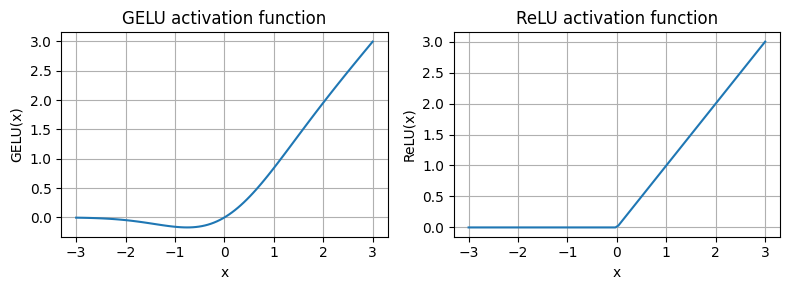

In [234]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- As we can see, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero
- GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)

- Next, let's implement the small neural network module, `FeedForward`, that we will be using in the LLM's transformer block later:

In [235]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
    
    def forward(self, x):
        return self.layers(x)

In [236]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="600px">

In [237]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="600px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="600px">

- Next, let's talk about the concept behind shortcut connections, also called skip or residual connections
- Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems
- A shortcut connection creates an alternative shorter path for the gradient to flow through the network
- This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between
- Let's illustrate this idea with a small example network:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="600px">

- In code, it looks like this:

In [238]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [239]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- Let's print the gradient values first **without** shortcut connections:

In [240]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152042235247791
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


- Next, let's print the gradient values **with** shortcut connections:

In [241]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


### 3.5 Connecting attention and linear layers in a transformer block

- In this section, we now combine the previous concepts into a so-called transformer block
- A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
- In addition, the transformer block also uses dropout and shortcut connections

In [242]:
# from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="600px">

- Suppose we have 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size
- You can think of the output as an augmented version of the context vectors we discussed in the previous chapter

In [243]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="600px">

### 3.6 Coding the GPT model

- We are almost there: now let's plug in the transformer block into the architecture we coded at the very beginning of this chapter so that we obtain a usable GPT architecture
- Note that the transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="600px">

- The corresponding code implementation, where `cfg["n_layers"] = 12`:

In [244]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

In [245]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


- We will train this model in the next chapter
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [246]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- As we see above, this model has 163M, not 124M parameters; why?
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
- So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [247]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
- Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [248]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- In practice, I found it easier to train the model without weight-tying, which is why we didn't implement it here
- However, we will revisit and apply this weight-tying idea later when we load the pretrained weights in chapter 5
- Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [249]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- Exercise: you can try the following other configurations, which are referenced in the [GPT-2 paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C), as well.

    - **GPT2-small** (the 124M configuration we already implemented):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

### 3.7 Generating text

- LLMs like the GPT model we implemented above are used to generate one word at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="600px">



- The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- In the next chapter, we will implement a more advanced `generate_text` function
- The figure below depicts how the GPT model, given an input context, generates the next word token



<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [250]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- The `generate_text_simple` above implements an iterative process, where it creates one token at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">


- Let's prepare an input example:

In [251]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [252]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- Remove batch dimension and convert back into text:

In [253]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Note that the model is untrained; hence the random output texts above
- We will train the model in the next chapter